curation report
============
Below are the FDPs listed in this index and their URIs that do not resolve. This can be a deliberate choice ( [4* link data)](https://5stardata.info/en/)) or require curators/data stewards attention.

In [1]:
import rdflib
import pandas as pd
import requests
import yaml
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from shexer.shaper import Shaper
from shexer.consts import NT, TURTLE

In [3]:

url = 'https://fdps.ejprd.semlab-leiden.nl/index/entries/all'
headers = {'accept': 'application/json'}

response = requests.get(url, headers=headers)
data = response.json()

df = pd.DataFrame(data)

In [17]:
fetched_urls = set()

def parse_graph(graph, fdp, url):
    try:
        graph.parse(url, format="ttl")
        uris[fdp]["resolve"].append(url)
        fetched_urls.add(url)
        return True
    except Exception as e:
        print("Could not parse: " + url)
        uris[fdp]["not_resolve"].append(url)
        print(e)
        return False

def fetchMetaData(graph, fdp, url):
    if parse_graph(graph, fdp, url):
        query = """
        PREFIX ldp: <http://www.w3.org/ns/ldp#>
        SELECT ?o WHERE {
            ?s ldp:contains ?o .
        }
        """
        results = graph.query(query)
        for row in results:
            resolve_url(graph, fdp, str(row["o"]) + "?format=ttl")

def resolve_url(graph, fdp, url):
    if parse_graph(graph, fdp, url):
        query = """
        PREFIX ldp: <http://www.w3.org/ns/ldp#>
        SELECT ?o WHERE {
            ?s ldp:contains ?o .
        }
        """

        datasetsgraph = rdflib.Graph()
        if parse_graph(datasetsgraph, fdp, url):
            datasetsgraph.parse(url, format="ttl")
            datasetsTempResults = datasetsgraph.query(query)
            for row in datasetsTempResults:
                resolve_url(datasetsgraph, fdp, str(row["o"]) + "?format=ttl")
uris = {}
fdpgraph = dict()

for index, row in df.iterrows():
    if not row['clientUrl'].endswith('/'):
        row['clientUrl'] = row['clientUrl'] + '/'
    fdpgraph[row['clientUrl']] = rdflib.Graph()
    uris[row['clientUrl']] = {"resolve": [], "not_resolve": []}
    fetchMetaData(fdpgraph[row['clientUrl']], row['clientUrl'], row['clientUrl'] + "?format=ttl")


KeyboardInterrupt



In [5]:
for fdp in fdpgraph.keys():
    print(fdp)
    print(len(fdpgraph[fdp].all_nodes()))

https://w3id.org/duchenne-fdp/
140
http://w3id.org/ern-euro-nmd-fdp/
87
https://w3id.org/ctsr-fdp/
68
https://w3id.org/smartcare-fdp/
76
https://w3id.org/fairvasc-fdp/
66


In [6]:
# print("Fetching linked data from the web")
for fdp in fdpgraph.keys():
    # print(fdp)
    for node in fdpgraph[fdp].all_nodes():
        if isinstance(node, rdflib.URIRef):
            url = str(node)
            if url not in fetched_urls:
                try:
                    # print("Fetching: " + url)
                    fdpgraph[str(fdp)].parse(url)
                    uris[fdp]["resolve"].append(url)
                    fetched_urls.add(url)
                except:
                    uris[str(fdp)]["not_resolve"].append(url)
                    # print("Could not parse: " + url)
                    continue


Fetching linked data from the web
https://w3id.org/duchenne-fdp/
Fetching: http://purl.obolibrary.org/obo/HP_0033333
Could not parse: http://purl.obolibrary.org/obo/HP_0033333
Fetching: http://www.w3.org/ns/dcat#dataset
Fetching: http://purl.obolibrary.org/obo/NCIT_C50184
Fetching: http://id.loc.gov/vocabulary/iso639-1/en
Fetching: http://purl.obolibrary.org/obo/HP_0033454
Could not parse: http://purl.obolibrary.org/obo/HP_0033454
Fetching: http://purl.obolibrary.org/obo/NCIT_C25271
Fetching: http://purl.obolibrary.org/obo/NCIT_C141702
Fetching: https://w3id.org/duchenne-fdp/catalog/
Could not parse: https://w3id.org/duchenne-fdp/catalog/
Fetching: https://www.wikidata.org/wiki/Q8777
Could not parse: https://www.wikidata.org/wiki/Q8777
Fetching: http://purl.org/spar/datacite/Identifier
Could not parse: http://purl.org/spar/datacite/Identifier
Fetching: http://purl.obolibrary.org/obo/NCIT_C176742
Fetching: http://semanticscience.org/resource/CHEMINF_000047
Fetching: http://purl.obolibra

In [7]:
def save_dict_to_yaml(dictionary, filepath):
    with open(filepath, 'w') as file:
        yaml.dump(dictionary, file)

# Save dictionary as YAML
save_dict_to_yaml(uris, 'uriLogs2.yaml')


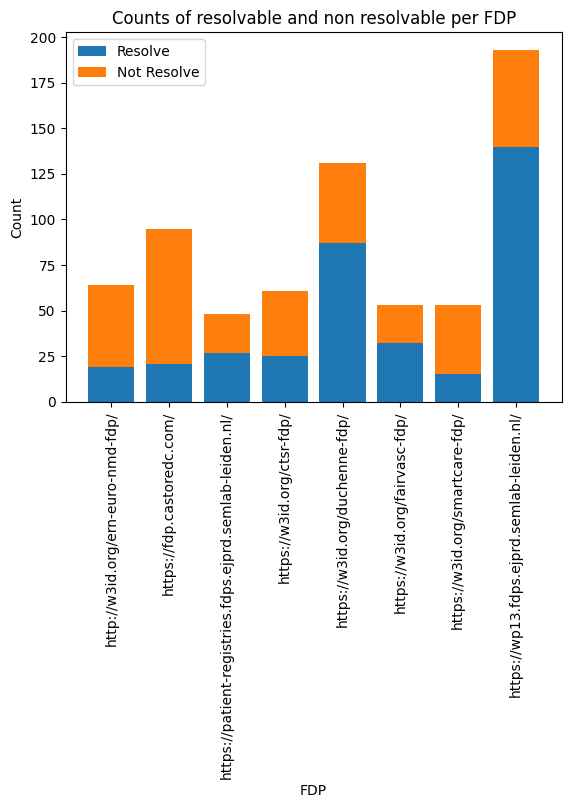

In [4]:
with open('uriLogs2.yaml', 'r') as file:
    data = yaml.safe_load(file)

resolve_counts = []
not_resolve_counts = []
servers = []

for server, values in data.items():
    resolve_count = len(values.get('resolve', []))
    not_resolve_count = len(values.get('not_resolve', []))
    servers.append(server)
    resolve_counts.append(resolve_count)
    not_resolve_counts.append(not_resolve_count)

plt.bar(servers, resolve_counts, label='Resolve')
plt.bar(servers, not_resolve_counts, label='Not Resolve', bottom=resolve_counts)
plt.xlabel('FDP')
plt.ylabel('Count')
plt.title('Counts of resolvable and non resolvable per FDP')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [18]:
from urllib.parse import urlparse
urls = dict()

for fdp in data.keys():
    urls[fdp] = dict()
    for url in data[fdp]["not_resolve"]:

        urlsections = urlparse(url)
        paths = urlsections.path.strip('/').split('/')
        if urlsections.netloc not in urls[fdp].keys():
            urls[fdp][urlsections.netloc] = []
        urls[fdp][urlsections.netloc].append(urlsections.path)

urls

{'http://w3id.org/ern-euro-nmd-fdp/': {'w3id.org': ['/ern-euro-nmd-fdp/metrics/5d27e854a9e78eb3f663331cd47cdc13',
   '/ern-euro-nmd-fdp/metrics/445c0a70d1e214e545b261559e2842f4',
   '/ern-euro-nmd-fdp/catalog/',
   '/fdp/fdp-o',
   '/fdp/fdp-o',
   '/ern-euro-nmd-fdp/catalog/9e38450d-89cb-4f78-ac50-0f048a633443/metrics/445c0a70d1e214e545b261559e2842f4',
   '/ern-euro-nmd-fdp/catalog/9e38450d-89cb-4f78-ac50-0f048a633443/metrics/5d27e854a9e78eb3f663331cd47cdc13',
   '/fdp/fdp-o',
   '/ern-euro-nmd-fdp/dataset/'],
  'bioregistry.io': ['/ncit:C101216',
   '/ncit:C84910',
   '/ncit:C129000',
   '/ncit:C28421',
   '/ncit:C70810',
   '/ncit:C18020',
   '/ncit:C25242',
   '/sio:SIO_001389',
   '/sio:SIO_010056',
   '/ncit:C15709',
   '/ncit:C4731',
   '/ncit:C16205',
   '/sio:SIO_001381',
   '/obo:HP_0003674',
   '/ncit:C159705',
   '/sio:SIO_001052',
   '/ncit:C156420',
   '/ncit:C68615',
   '/edam:data_1153',
   '/ncit:C102741',
   '/obo:DUO_0000001',
   '/sio:SIO_001001'],
  'www.wikidata.o

# 4* URIs (Unresolved)

In [19]:
def dict_to_markdown_list(d):
    md = ''
    for k, v in d.items():
        if isinstance(v, list):
            md += f'- **{k}:**\n'
            for item in v:
                md += f'  - {item}\n'
        elif isinstance(v, dict):
            md += f'## {k}\n'
            md += dict_to_markdown_list(v)
        else:
            md += f'- **{k}:** {v}\n'
    return md

md = dict_to_markdown_list(urls)

display(Markdown(md))

## http://w3id.org/ern-euro-nmd-fdp/
- **w3id.org:**
  - /ern-euro-nmd-fdp/metrics/5d27e854a9e78eb3f663331cd47cdc13
  - /ern-euro-nmd-fdp/metrics/445c0a70d1e214e545b261559e2842f4
  - /ern-euro-nmd-fdp/catalog/
  - /fdp/fdp-o
  - /fdp/fdp-o
  - /ern-euro-nmd-fdp/catalog/9e38450d-89cb-4f78-ac50-0f048a633443/metrics/445c0a70d1e214e545b261559e2842f4
  - /ern-euro-nmd-fdp/catalog/9e38450d-89cb-4f78-ac50-0f048a633443/metrics/5d27e854a9e78eb3f663331cd47cdc13
  - /fdp/fdp-o
  - /ern-euro-nmd-fdp/dataset/
- **bioregistry.io:**
  - /ncit:C101216
  - /ncit:C84910
  - /ncit:C129000
  - /ncit:C28421
  - /ncit:C70810
  - /ncit:C18020
  - /ncit:C25242
  - /sio:SIO_001389
  - /sio:SIO_010056
  - /ncit:C15709
  - /ncit:C4731
  - /ncit:C16205
  - /sio:SIO_001381
  - /obo:HP_0003674
  - /ncit:C159705
  - /sio:SIO_001052
  - /ncit:C156420
  - /ncit:C68615
  - /edam:data_1153
  - /ncit:C102741
  - /obo:DUO_0000001
  - /sio:SIO_001001
- **www.wikidata.org:**
  - /wiki/Q8777
- **purl.org:**
  - /spar/datacite/Identifier
  - /ejp-rd/vocabulary/PatientRegistry
  - /ejp-rd/vocabulary/VPDiscoverable
  - /ejp-rd/vocabulary/VPQueryable
- **xmlns.com:**
  - /foaf/0.1/Agent
- **www.orpha.net:**
  - /ORDO/Orphanet_98503
  - /ORDO/Orphanet_98491
  - /ORDO/Orphanet_68380
  - /ORDO/Orphanet_68381
- **registry.ern-euro-nmd.eu:**
  - /
- **purl.bioontology.org:**
  - /ontology/LNC/MTHU854719
- **rdflicense.appspot.com:**
  - /rdflicense/cc-by-nc-nd3.0
- **www.ietf.org:**
  - /rfc/rfc3986.txt
## https://w3id.org/ctsr-fdp/
- **w3id.org:**
  - /ctsr-fdp/catalog2/8fa78605-8025-4e0c-bf63-4da64ee727a2
  - /ctsr-fdp/catalog2/c1934541-a329-4139-96a2-a784c602b9da
  - /ctsr-fdp/diagnosis_cohort/410fd1da-df02-4df5-b839-821880c41fe4
  - /ctsr-fdp/contact_organization/3aebd836-43fa-449a-8925-f2611d266650
  - /ctsr-fdp/contact_organization/3aebd836-43fa-449a-8925-f2611d266650
  - /ctsr-fdp/age_cohort/22a73747-d36f-41e3-815d-fcadcde9cd57
  - /ctsr-fdp/site/070a6704-67c5-4318-8643-5741e7222343
  - /ctsr-fdp/contact_individual/9f1a623c-a114-40e3-866e-ab61bcb1aa57
  - /ctsr-fdp/contact_individual/9f1a623c-a114-40e3-866e-ab61bcb1aa57
  - /ctsr-fdp/contact_organization/9452f804-c205-44b0-8472-9f88acebf899
  - /ctsr-fdp/contact_organization/9452f804-c205-44b0-8472-9f88acebf899
  - /ctsr-fdp/catalog/87acc8da-4885-4b73-85f4-7caaa062600b/metrics/5d27e854a9e78eb3f663331cd47cdc13
  - /ctsr-fdp/dataset/
  - /ctsr-fdp/metrics/445c0a70d1e214e545b261559e2842f4
  - /ctsr-fdp/catalog/87acc8da-4885-4b73-85f4-7caaa062600b/metrics/445c0a70d1e214e545b261559e2842f4
  - /ctsr-fdp/catalog2/c1934541-a329-4139-96a2-a784c602b9da
  - /ctsr-fdp/site/070a6704-67c5-4318-8643-5741e7222343
  - /fdp/fdp-o
  - /ctsr-fdp/contact_individual/9f1a623c-a114-40e3-866e-ab61bcb1aa57
  - /ctsr-fdp/metrics/5d27e854a9e78eb3f663331cd47cdc13
  - /ctsr-fdp/site/
  - /fdp/fdp-o
  - /ctsr-fdp/contact_organization/
  - /ctsr-fdp/contact_organization/9452f804-c205-44b0-8472-9f88acebf899
  - /ctsr-fdp/contact_individual/
  - /ctsr-fdp/catalog/
  - /fdp/fdp-o
  - /ctsr-fdp/catalog2/8fa78605-8025-4e0c-bf63-4da64ee727a2
- **creativecommons.org:**
  - /licenses/by/4.0
- **www.wikidata.org:**
  - /wiki/Q8777
- **purl.org:**
  - /spar/datacite/Identifier
  - /ejp-rd/vocabulary/VPDiscoverable
- **rdflicense.appspot.com:**
  - /rdflicense/cc-by-nc-nd3.0
- **www.ietf.org:**
  - /rfc/rfc3986.txt
- **xmlns.com:**
  - /foaf/0.1/Agent
- **ctsr.uniklinik-freiburg.de:**
  - /ctsr/
## https://w3id.org/duchenne-fdp/
- **purl.obolibrary.org:**
  - /obo/HP_0033333
  - /obo/HP_0033454
  - /obo/HP_0020110
  - /obo/HP_0002650
  - /obo/UBERON_0001434
  - /obo/HP_0002194
  - /obo/HP_0009473
  - /obo/HP_0008366
  - /obo/HP_0006380
  - /obo/HP_0002014
  - /obo/HP_0000750
  - /obo/HP_0005997
  - /obo/HP_0000708
  - /obo/HP_0003270
  - /obo/HP_0002019
  - /obo/HP_0032321
  - /obo/HP_0008981
  - /obo/HP_0006957
  - /obo/HP_0030193
  - /obo/HP_0001270
  - /obo/HP_0002987
  - /obo/HP_0003044
  - /obo/HP_0002020
  - /obo/HP_0000819
  - /obo/HP_0001263
- **w3id.org:**
  - /duchenne-fdp/catalog/
  - /duchenne-fdp/catalog/ce01b2e8-3a1d-434e-b5e2-98e3a8d78a5b/metrics/445c0a70d1e214e545b261559e2842f4
  - /duchenne-fdp/metrics/5d27e854a9e78eb3f663331cd47cdc13
  - /fdp/fdp-o
  - /duchenne-fdp/metrics/445c0a70d1e214e545b261559e2842f4
  - /fdp/fdp-o
  - /duchenne-fdp/dataset/
  - /fdp/fdp-o
  - /duchenne-fdp/catalog/ce01b2e8-3a1d-434e-b5e2-98e3a8d78a5b/metrics/5d27e854a9e78eb3f663331cd47cdc13
- **www.wikidata.org:**
  - /wiki/Q8777
- **purl.org:**
  - /spar/datacite/Identifier
  - /ejp-rd/vocabulary/VPDiscoverable
  - /ejp-rd/vocabulary/VPQueryable
- **xmlns.com:**
  - /foaf/0.1/Agent
- **www.orpha.net:**
  - /ORDO/Orphanet_98895
  - /ORDO/Orphanet_98896
- **rdflicense.appspot.com:**
  - /rdflicense/cc-by-nc-nd4.0
- **www.dpp_ontology.net:**
  - /terms/Intermediate
- **www.ietf.org:**
  - /rfc/rfc3986.txt
## https://w3id.org/fairvasc-fdp/
- **w3id.org:**
  - /fairvasc-fdp/dataset/944d9f70-5f80-42c5-a0da-b8025e1dd6c2
  - /fdp/fdp-o
  - /fairvasc-fdp/dataset/944d9f70-5f80-42c5-a0da-b8025e1dd6c2
  - /fairvasc-fdp/catalog/
  - /fairvasc-fdp/catalog/b1cd4da5-566b-40c0-a70f-ef8390057a05/metrics/445c0a70d1e214e545b261559e2842f4
  - /fairvasc-fdp/metrics/5d27e854a9e78eb3f663331cd47cdc13
  - /fdp/fdp-o
  - /fairvasc-fdp/metrics/445c0a70d1e214e545b261559e2842f4
  - /fairvasc-fdp/catalog/b1cd4da5-566b-40c0-a70f-ef8390057a05/metrics/5d27e854a9e78eb3f663331cd47cdc13
  - /fairvasc-fdp/dataset/
  - /fdp/fdp-o
- **fairvasc.eu:**
  - /
- **www.wikidata.org:**
  - /wiki/Q8777
- **purl.org:**
  - /spar/datacite/Identifier
  - /ejp-rd/vocabulary/VPDiscoverable
- **www.ietf.org:**
  - /rfc/rfc3986.txt
- **identifiers.org:**
  - /orphanet:727
  - /orphanet:183
  - /orphanet:900
  - /orphanet:156152
- **xmlns.com:**
  - /foaf/0.1/Agent
## https://w3id.org/smartcare-fdp/
- **w3id.org:**
  - /smartcare-fdp/metrics/445c0a70d1e214e545b261559e2842f4
  - /smartcare-fdp/catalog/f453e170-5a9f-4e30-bb35-649e9690be10/metrics/5d27e854a9e78eb3f663331cd47cdc13
  - /smartcare-fdp/metrics/5d27e854a9e78eb3f663331cd47cdc13
  - /smartcare-fdp/dataset/
  - /smartcare-fdp/catalog/f453e170-5a9f-4e30-bb35-649e9690be10/metrics/445c0a70d1e214e545b261559e2842f4
  - /fdp/fdp-o
  - /smartcare-fdp/catalog/
  - /fdp/fdp-o
  - /fdp/fdp-o
- **bioregistry.io:**
  - /orphanet.ordo:83330
  - /orphanet.ordo:83420
  - /ncit:C70810
  - /ncit:C166875
  - /ncit:C167001
  - /ncit:C174715
  - /orphanet.ordo:83418
  - /ncit:C25242
  - /ncit:C115789
  - /omim:601627
  - /orphanet.ordo:83419
  - /orphanet.ordo:70
  - /obo:HP_0003674
  - /ncit:C159705
  - /sio:SIO_001052
  - /ncit:C156420
  - /ncit:C68615
  - /ncit:C129000
  - /ncit:C28421
  - /sio:SIO_001001
  - /omim:600354
- **creativecommons.org:**
  - /licenses/by/4.0
- **www.wikidata.org:**
  - /wiki/Q8777
- **purl.org:**
  - /spar/datacite/Identifier
  - /ejp-rd/vocabulary/VPDiscoverable
- **rdflicense.appspot.com:**
  - /rdflicense/cc-by-nc-nd3.0
- **www.ietf.org:**
  - /rfc/rfc3986.txt
- **xmlns.com:**
  - /foaf/0.1/Agent
- **www.smartcare.de:**
  - /en/index.html
